#### Code reference:  nbviewer.jupyter.org/github/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

In [75]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import ShuffleSplit
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.features import RadViz
from yellowbrick.regressor import PredictionError
from yellowbrick.regressor import CooksDistance
from sklearn.model_selection import train_test_split

In [53]:
#import vehicle dataset
clean_df = pd.read_csv('data/out.csv') 

In [54]:
#create a copy
car_df = clean_df.copy()

In [55]:
#Drop the columns that we will not be using to build models.
car_df = car_df.drop(columns=['model', 'price_range','posting_date']) 

In [56]:
#check data
car_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137526 entries, 0 to 137525
Data columns (total 13 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   price             137526 non-null  int64  
 1   manufacturer      137526 non-null  object 
 2   cylinders         137526 non-null  int64  
 3   fuel              137526 non-null  object 
 4   odometer          137526 non-null  float64
 5   title_status      137526 non-null  object 
 6   state             137526 non-null  object 
 7   drive_new         137526 non-null  object 
 8   condition_new     137526 non-null  object 
 9   transmission_new  137526 non-null  object 
 10  type_new          137526 non-null  object 
 11  paint_color_new   137526 non-null  object 
 12  car_Age_in_yrs    137526 non-null  float64
dtypes: float64(2), int64(2), object(9)
memory usage: 13.6+ MB


In [57]:
#One hot encoding of all the features
car_df_ohe_original = pd.get_dummies(car_df[['price',
                                        'manufacturer', 
                                        'cylinders', 
                                        'fuel', 
                                        'odometer',
                                        'title_status', 
                                        'drive_new', 
                                        'condition_new', 
                                        'transmission_new', 
                                        'type_new', 
                                        'paint_color_new',
                                        'car_Age_in_yrs',
                                        'state']],  drop_first=True)

car_df_ohe_original.info()
print(car_df_ohe_original.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137526 entries, 0 to 137525
Columns: 122 entries, price to state_wy
dtypes: float64(2), int64(2), uint8(118)
memory usage: 19.7 MB
Index(['price', 'cylinders', 'odometer', 'car_Age_in_yrs',
       'manufacturer_alfa-romeo', 'manufacturer_aston-martin',
       'manufacturer_audi', 'manufacturer_bmw', 'manufacturer_buick',
       'manufacturer_cadillac',
       ...
       'state_sd', 'state_tn', 'state_tx', 'state_ut', 'state_va', 'state_vt',
       'state_wa', 'state_wi', 'state_wv', 'state_wy'],
      dtype='object', length=122)


In [58]:
#create a copy of the ohe data
car_df_ohe = car_df_ohe_original.copy()

In [59]:
#create X, y
y = car_df_ohe['price'].values
del car_df_ohe['price'] 
X = car_df_ohe.values

In [60]:
#scale X
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()
scl_obj.fit(X) # find scalings for each column that make this zero mean and unit std
X_scaled = scl_obj.transform(X)

In [61]:
#print shape of X, y
print(X_scaled.shape)
print(y.shape)

(137526, 121)
(137526,)


In [62]:
#sample 30,000 records for Random Forest to reduce processing time for GridSearch
car_df_30k = car_df_ohe_original.sample(n=30000, random_state=42)

In [63]:
#create X, y for sampled data
y_30k = car_df_30k['price'].values
del car_df_30k['price'] 
X_30k = car_df_30k.values

In [64]:
#scale the sampled data
scl_obj.fit(X_30k) # find scalings for each column that make this zero mean and unit std
X_scaled_30k = scl_obj.transform(X_30k)

In [65]:
#print shape of X, y
print(X_scaled_30k.shape)
print(y_30k.shape)

(30000, 121)
(30000,)


### Cross Validation

In [66]:
#divide data into train/test splits
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

In [67]:
# Create a train and test dataset for Residual and Error plots
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### Review Outliers

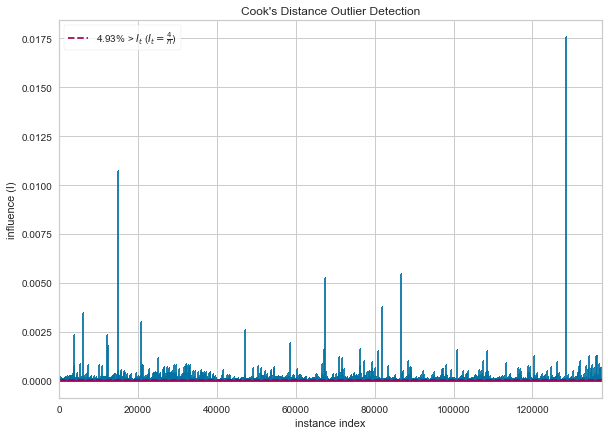

<AxesSubplot:title={'center':"Cook's Distance Outlier Detection"}, xlabel='instance index', ylabel='influence (I)'>

In [68]:
#create an outlier plot
visualizer = RadViz(size=(700,500))

#instantiate and fit the visualizer
visualizer = CooksDistance()
visualizer.fit(X_scaled, y)
visualizer.show()

### Custom Scorers

**All regression models created in this notebook are validated using the following metrics:**
* Mean Absolute Error (MAE)
* Root Mean Squared Error (RMSE) - https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python

In [69]:
#use root mean squared error (RMSE) and mean abslute error (MAE) to score the regression models created
#the scale of RMSE and MAE is identical to the response variable
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error

#function for root mean squared error (RMSE)
def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

#create scorers for rmse and mape functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)

#make scorer array to pass into cross_validate() function for producing multiple scores for each cv fold
errorScoring = {'MAE':  mae_scorer,
                'RMSE': rmse_scorer}

### Regression Model Evaluation

In [70]:
#function to evaluate regression models using the cross validation object & custom scorers above
from sklearn.model_selection import cross_validate

def EvaluateRegressionEstimator(regEstimator, X, y, cv):
    
    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)
    
    #cross val score sign-flips the outputs of MAE
    #https://github.com/scikit-learn/scikit-learn/issues/2439
    scores['test_MAE'] = scores['test_MAE'] * -1
    scores['test_RMSE'] = scores['test_RMSE'] * -1
    
    #print mean MAE for all folds
    maeAvg = scores['test_MAE'].mean()
    print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg: .5}"
    print(print_str.format(maeAvg=maeAvg))
    

    #print mean RMSE for all folds
    RMSEavg = scores['test_RMSE'].mean()
    print_str = "The average RMSE for all cv folds is:  \t\t\t {RMSEavg: .5}"
    print(print_str.format(RMSEavg=RMSEavg))
    print('***************************************************************')
    
    print("Cross Validation Fold Mean Error Scores")
    scoresResults = pd.DataFrame()
    scoresResults['MAE'] = scores['test_MAE']
    scoresResults['RMSE'] = scores['test_RMSE']
    return scoresResults

### Baseline Regression Model - Cross Validation

**Perform tenfold cross validation using the grid search "best" parameters **
* 10-fold cross-validation using the parameters for the top performing model
* Evaluate cross-validation results using MAE and RMSE

In [71]:
#create a linear regression object and perform a grid search to find the best parameters
reg = LinearRegression()

#test parameters
normalize = [True, False]
fit_intercept = [True, False]
parameters = {'normalize': normalize, 'fit_intercept':fit_intercept}

#create a grid search object
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                            , verbose=1 #low verbosity
                            , param_grid=parameters
                            , cv=cv #KFolds=10
                            , scoring=mae_scorer)

In [72]:
#perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_scaled, y)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
             estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [73]:
#display the best estimator parameters
regGridSearch.best_estimator_

LinearRegression(normalize=True)

In [76]:
%%time

#create Linear Regression predictions using the best parameters for our Linear Regression object
regEstimator = regGridSearch.best_estimator_

#evaluate the regression estimator above using our pre-defined cross validation and scoring metrics
EvaluateRegressionEstimator(regEstimator, X_scaled, y, cv)

The average MAE for all cv folds is: 			  3864.6
The average RMSE for all cv folds is:  			  9240.2
***************************************************************
Cross Validation Fold Mean Error Scores
Wall time: 8.94 s


,MAE,RMSE
0,3858.170504,5885.762380
1,3805.510895,5391.933930
2,3891.898399,12415.765716
3,3906.370910,16262.047219
4,3815.901660,5400.777174
5,3824.556121,5443.766355
6,3838.876766,5413.885072
7,3992.173277,25265.499188
8,3853.647057,5445.190547
9,3858.585317,5477.225909


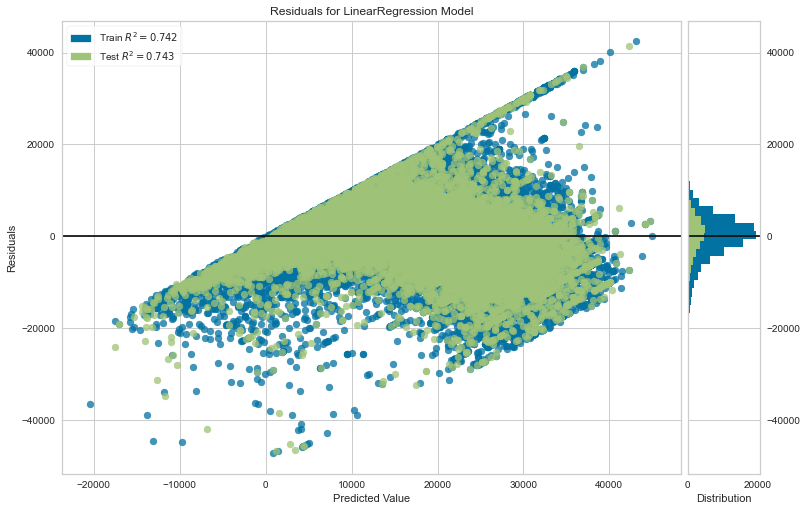

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [77]:
#create residual plot
visualizer = RadViz(size=(900, 600))

#instantiate the visualizer
visualizer = ResidualsPlot(regEstimator)

# visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
# visualizer.score(X_test, y_test)  # Evaluate the model on the test data
# visualizer.show()                 # Finalize and render the figure
# Create the visualizer, fit, score, and show it
viz = residuals_plot(regEstimator, X_train, y_train, X_test, y_test)

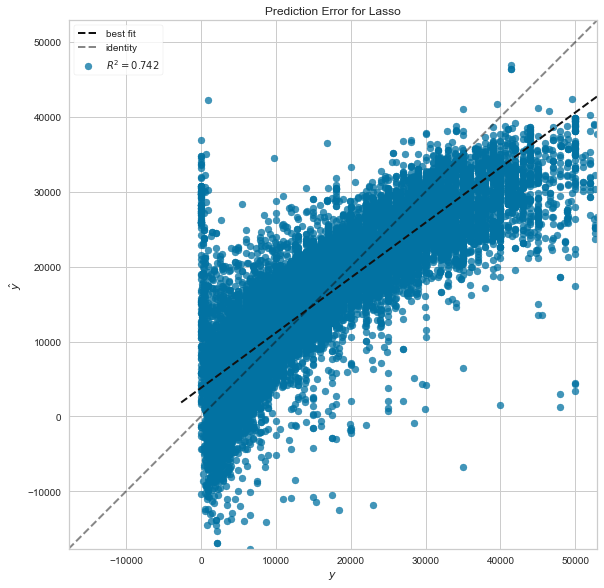

<AxesSubplot:title={'center':'Prediction Error for Lasso'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [78]:
#create error plot
visualizer = RadViz(size=(700,700))
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

### Lasso Regression

**This model uses Lasso regression (L1 Norm)**  

In [79]:
#create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Lasso

reg = Lasso(fit_intercept=True, normalize=True, copy_X=True, max_iter=10000, precompute=True, tol=0.0001, random_state=42)

#test parameters
alpha = [0.001, 0.1, 1, 10, 20]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                             , n_jobs=8 #run jobs in parallet
                             , verbose=1 #low verbosity
                             , param_grid=parameters
                             , cv=cv #KFolds = 10
                             , scoring=mae_scorer)

#perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_scaled, y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
             estimator=Lasso(max_iter=10000, normalize=True, precompute=True,
                             random_state=42),
             n_jobs=8,
             param_grid={'alpha': [0.001, 0.1, 1, 10, 20],
                         'selection': ['cyclic', 'random'],
                         'warm_start': [True, False]},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [80]:
#display the best estimator parameters
regGridSearch.best_estimator_

Lasso(alpha=0.001, max_iter=10000, normalize=True, precompute=True,
      random_state=42, warm_start=True)

In [81]:
%%time

from sklearn.linear_model import Lasso

#create a regression estimator with best parameters for cross validation
regEstimator = Lasso(alpha=0.001, max_iter=10000, normalize=True, precompute=True,
      random_state=42, selection='random', warm_start=True)

#evaluate the regression estimator above using our pre-defined cross validation and scoring metrics
EvaluateRegressionEstimator(regEstimator, X_scaled, y, cv)

The average MAE for all cv folds is: 			  3832.5
The average RMSE for all cv folds is:  			  5428.4
***************************************************************
Cross Validation Fold Mean Error Scores
Wall time: 5.85 s


,MAE,RMSE
0,3845.021312,5483.840069
1,3805.317431,5391.906843
2,3824.543205,5398.428664
3,3815.111012,5409.976717
4,3815.615447,5400.491472
5,3824.594984,5443.841527
6,3838.809996,5413.846915
7,3843.782283,5419.117610
8,3853.587529,5445.186626
9,3858.465832,5477.110523


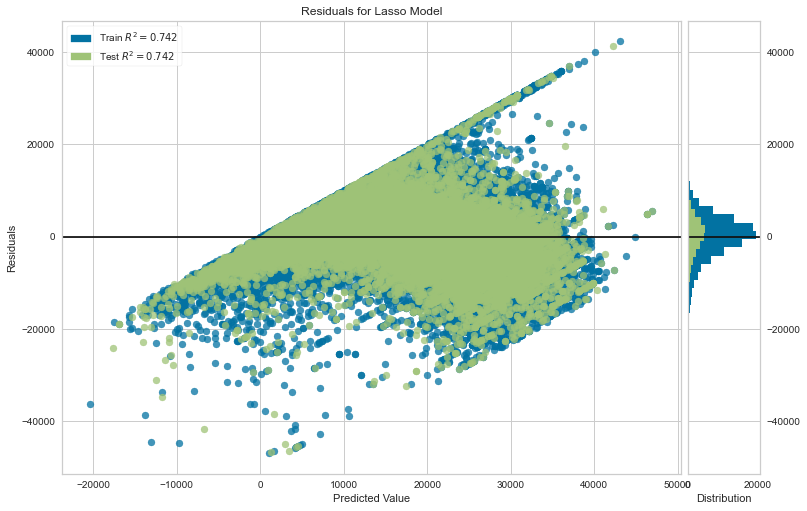

<AxesSubplot:title={'center':'Residuals for Lasso Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [82]:
#create residual plots
visualizer = RadViz(size=(900, 600))

#instantiate the visualizer
visualizer = ResidualsPlot(regEstimator)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

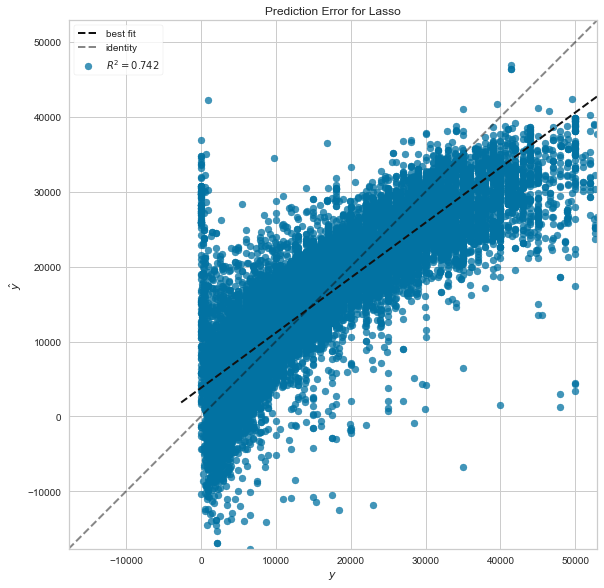

<AxesSubplot:title={'center':'Prediction Error for Lasso'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [83]:
#prediction error plot
visualizer = RadViz(size=(700,700))
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

### Ridge Regression

**This model uses Ridge regression (L2 Norm)**  
Documentation: http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html 

In [84]:
#create a regression object and perform a grid search to find the best parameters
from sklearn.linear_model import Ridge

reg = Ridge(fit_intercept=True, normalize=True, copy_X=True, max_iter=1000, tol=0.0001, random_state=42)

#test parameters
alpha = [0.001, 0.1, 1, 5, 10, 20]
solver = ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
parameters = {'alpha': alpha, 'solver': solver}

#create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV

regGridSearch = GridSearchCV (estimator=reg
                             , n_jobs=8 #jobs to run in parallel
                             , verbose=1 #low verbosity
                             , param_grid=parameters
                             , cv=cv #KFold = 10
                             , scoring = mae_scorer)

In [85]:
%%time
#perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_scaled, y)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Wall time: 9min 54s


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=42, test_size=0.2, train_size=None),
             estimator=Ridge(max_iter=1000, normalize=True, random_state=42,
                             tol=0.0001),
             n_jobs=8,
             param_grid={'alpha': [0.001, 0.1, 1, 5, 10, 20],
                         'solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg',
                                    'sag', 'saga']},
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [86]:
#display the best estimator parameters
regGridSearch.best_estimator_

Ridge(alpha=0.001, max_iter=1000, normalize=True, random_state=42, solver='svd',
      tol=0.0001)

In [87]:
#create a regression estimator with best parameters for cross validation
regEstimator = regGridSearch.best_estimator_

#evaluate the regression estimator above using our pre-definted cross validation and scoring metrics
EvaluateRegressionEstimator(regEstimator, X_scaled, y, cv)

The average MAE for all cv folds is: 			  3863.6
The average RMSE for all cv folds is:  			  9109.1
***************************************************************
Cross Validation Fold Mean Error Scores


,MAE,RMSE
0,3860.017644,6028.996945
1,3805.110627,5391.951590
2,3888.135157,11885.335737
3,3903.961246,15953.668986
4,3815.349543,5400.466117
5,3824.278095,5443.736535
6,3838.717085,5413.875858
7,3988.527656,24651.034827
8,3853.379156,5445.207546
9,3858.255813,5476.970346


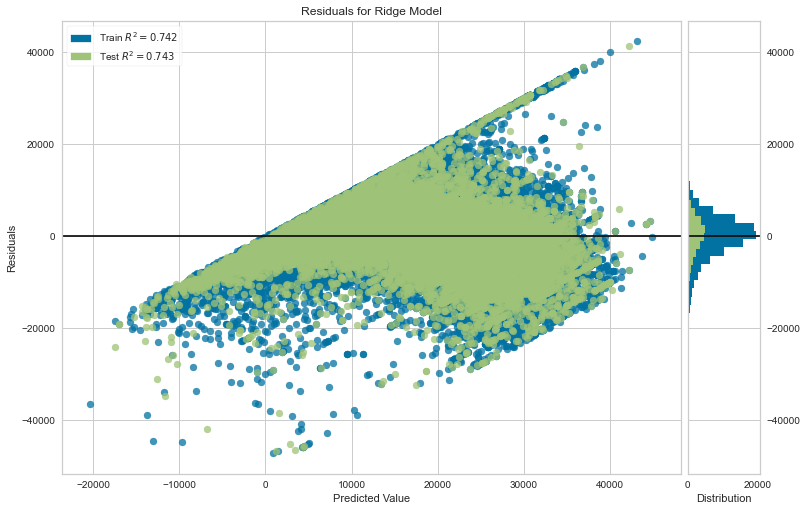

<AxesSubplot:title={'center':'Residuals for Ridge Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [88]:
#create residual plot
visualizer = RadViz(size=(900, 600))

#instantiate the visualizer
visualizer = ResidualsPlot(regEstimator)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

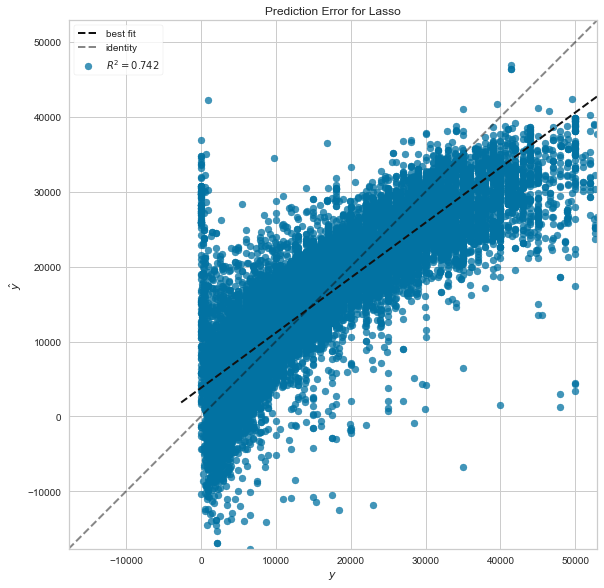

<AxesSubplot:title={'center':'Prediction Error for Lasso'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [89]:
#create error plot
visualizer = RadViz(size=(700,700))
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure

### Random Forest Regressor

**This model uses a custom Logit model using the Random Forest Regressor. Please see documentation here:**
* http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
* https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/
* https://www.kaggle.com/general/4092

In [90]:
#create a linear regression object and perform a grid search to find the best parameters
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor()
parameters = {'min_samples_split': [2, 5]
             , 'n_estimators':[100]
             , 'min_samples_leaf':[10,50]
             , 'criterion': ['mae']
             , 'n_jobs': [8]
             , 'random_state':[42]
             }

#create a grid serarch object 
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator = reg
                             , n_jobs = 8
                             , verbose = 1 #low verbosity
                             , param_grid = parameters
                             , cv=cv #KFolds = 10
                             , scoring = mae_scorer)

In [ ]:
%%time
#perform hyperparameter search to find the best combination of parameters for our data
#regGridSearch.fit(X_scaled_30k, y_30k) - UNCOMMENT TO RUN GRIDSEARCH FOR RF

In [ ]:
#display the best estimator parameters
#regGridSearch.best_estimator_  - UNCOMMENT TO RUN GRIDSEARCH FOR RF

#results of grid search 
#RandomForestRegressor(criterion='mae', min_samples_leaf=10, n_jobs=8, random_state=42)

In [ ]:
%%time
#create a regression estimator with the best parameters for cross validation
#regEstimator = regGridSearch.best_estimator_  - UNCOMMENT TO RUN GRIDSEARCH FOR RF

regEstimator =  RandomForestRegressor(criterion='mae', min_samples_leaf=10, n_jobs=8,
                      random_state=42)

#evaluate the regression estimatoro above using our pre-defined cross validation and scoring metrics
EvaluateRegressionEstimator(regEstimator, X_scaled_30k, y_30k, cv)

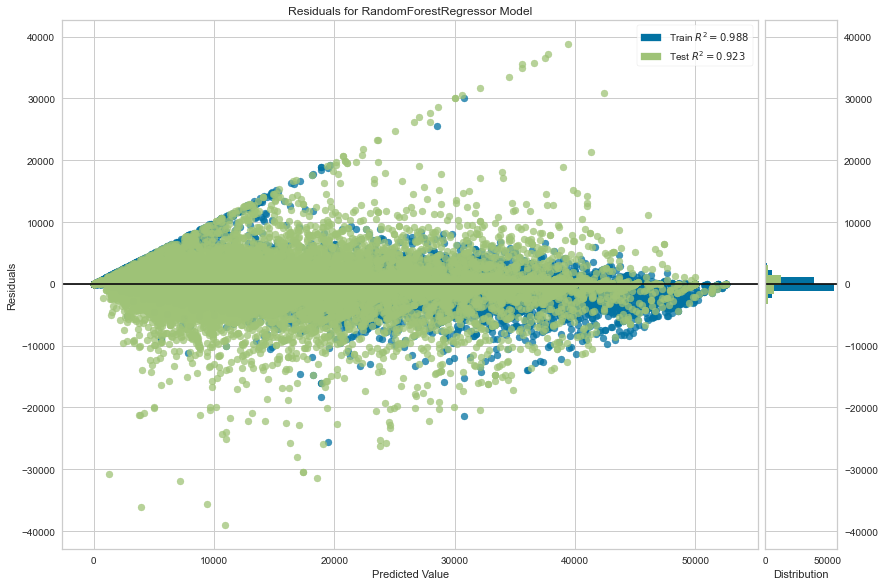

In [38]:
#create residual plot
from yellowbrick.regressor import residuals_plot
visualizer = RadViz(size=(900, 600))

# Create the visualizer, fit, score, and show it
viz = residuals_plot(regEstimator, X_train, y_train, X_test, y_test)

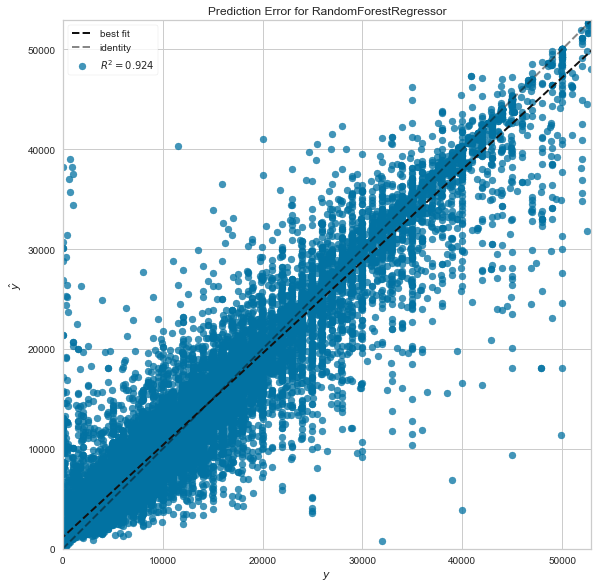

<AxesSubplot:title={'center':'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [39]:
#create error plot
visualizer = RadViz(size=(700,700))
visualizer = PredictionError(regEstimator)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()                 # Finalize and render the figure